In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


# Monte Carlo Wavefunction Method

In [1]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads

# Example 1: Radiative Damping

Here we consider the (base) jumps and hamiltonian:
$$ H = \frac{\Delta\omega}{2}\sigma_z $$
$$ L = \sqrt{\gamma}\sigma_- $$

with a $T$ parametrization and coherent fields

In [19]:
Tid = 1/sqrt(2) * [1 1im; 1 1im]
function rotation_matrix(theta)
    R = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    return R
end
ntimes = 200
params = BackAction.rd_params;
t_eval = collect(LinRange(0.0, params.tf, ntimes));

In [20]:
function get_z_sample(theta)
    T = rotation_matrix(theta)*Tid#reshape([1.0 + 0.0im], 1,1)
    alphas = [3.3 + 0.0im; 3.3 + 0.0im]
    sys = System(BackAction.rd_H, [BackAction.rd_L], T, alphas)
    sim = get_sol_jumps(sys, params, t_eval)
    z_sample = Array{Float64}(undef, ntimes, params.ntraj)
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                     psi = sim[n](t_eval[t])
                     z_sample[t, n] = real(dot(psi, BackAction.sigma_z, psi))/dot(psi, psi)
                 end
    end 
    return z_sample
end 

get_z_sample (generic function with 1 method)

In [21]:
z_sample1 = get_z_sample(1.5);
z_sample2 = get_z_sample(1.8);
z_sample3 = get_z_sample(0.8);

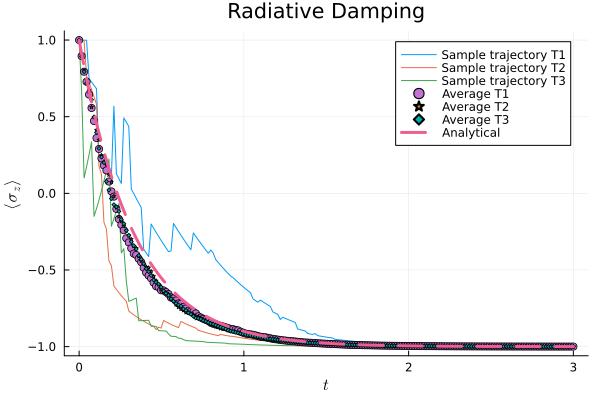

In [22]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
plot!(t_eval, z_sample2[:, 2], label="Sample trajectory T2")
plot!(t_eval, z_sample3[:, 3], label="Sample trajectory T3")
scatter!(t_eval, dropdims(mean(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(mean(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(mean(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)
plot!(t_eval, t -> 2*exp(-BackAction.rd_gamma*t) - 1, label="Analytical", linewidth=3, line=:dash)

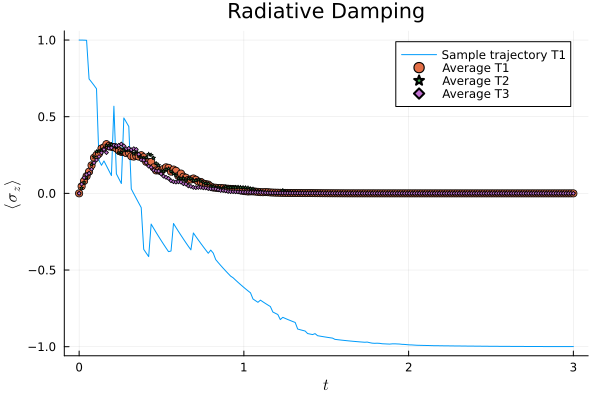

In [24]:
plot(t_eval, z_sample1[:, 1], label="Sample trajectory T1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle", title="Radiative Damping")
scatter!(t_eval, dropdims(var(z_sample1, dims=2), dims=2), label="Average T1")
scatter!(t_eval, dropdims(var(z_sample2, dims=2), dims=2), label="Average T2", markersize=2, markershape=:star)
scatter!(t_eval, dropdims(var(z_sample3, dims=2), dims=2), label="Average T3", markersize=2, markershape=:diamond)

# Example 2: Driven Qubit


In [2]:
function su2_matrix(theta, phi, psi)
    return [exp(1im*phi)*cos(theta) exp(1im*psi)*sin(theta); -exp(-1im*psi)*sin(theta) exp(-1im*phi)*cos(theta)]
end 

su2_matrix (generic function with 1 method)

In [9]:
# Parameters and time evaluation
ntimes = 75
params = SimulParameters([1.0+0im; 0.0], #initial condition
    25.0, #tf
    1, # seed
    5_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
t_eval = collect(LinRange(0.0, params.tf, ntimes));
gamma = 1.0
delta = 0.5
omega = 0.5
nbar= 0.0

H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L1 = sqrt(gamma*(nbar+1))*BackAction.sigma_m
L2 = sqrt(gamma*(nbar))*BackAction.sigma_p
T1 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T2 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
T3 = su2_matrix(2pi*rand(), 2*pi*rand(), 2*pi*rand())
alphas = [1.0 + 0.0im; 1.0 + 0.0im]

 

2-element Vector{ComplexF64}:
 1.0 + 0.0im
 1.0 + 0.0im

In [10]:
function get_r_sample(T)
    sys = System(H, [L1, L2], T, alphas)
    # Problem definition
    @time begin
    sim = get_sol_jumps(sys, params, t_eval);
    end
    # observable evaluation 
    r_sample = Array{Float64}(undef, 3, ntimes,params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
    @threads for n in 1:params.ntraj
                 for t in 1:ntimes
                    psi = sim[n](t_eval[t])
                    for k in 1:3
                        r_sample[k, t, n] = real(dot(psi, sigma[k], psi))/dot(psi, psi)
                     end
                 end 
            end 
    return r_sample
end

get_r_sample (generic function with 1 method)

In [11]:
# Parameters definition and problem initialization
r_sample1 = get_r_sample(T1);
r_sample2 = get_r_sample(T2);
r_sample3 = get_r_sample(T3);

  9.315174 seconds (190.98 M allocations: 16.364 GiB, 36.97% gc time, 0.09% compilation time)
 15.279922 seconds (240.88 M allocations: 20.608 GiB, 56.56% gc time)
  7.271241 seconds (174.07 M allocations: 14.924 GiB, 38.71% gc time)


In [12]:
# Analytical solution
function resonance_fluorescene!(du, u, p, t)
    #     -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    # delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3];
    # omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma]

    du[1] = - 0.5*gamma*(2*nbar+1)*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*gamma*(2*nbar+1)*u[2]- omega*u[3]  
    du[3] = omega*u[2] - gamma*(2*nbar+1)*u[3] - gamma
end
u0 = [0.0, 0.0, -1.0]
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(t_eval))
sol_analytical = solve(prob_analytical);

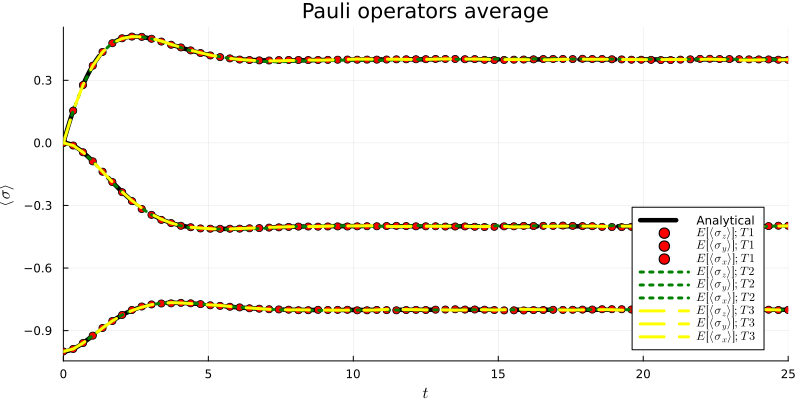

In [13]:
# Analytical
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,2), label=false, color="black",line=:dash, linewidth=4.5)
plot!(sol_analytical, idxs=(0,1), label=false, color="black",line=:dash, linewidth=4.5)
# T1
scatter!(t_eval, dropdims(mean(r_sample1[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Pauli operators average", size=(800, 400))
scatter!(t_eval, dropdims(mean(r_sample1[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
        )
scatter!(t_eval, dropdims(mean(r_sample1[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
        )
# T2
plot!(t_eval, dropdims(mean(r_sample2[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
    line=:dot)
plot!(t_eval, dropdims(mean(r_sample2[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
    line=:dot)
#T3
plot!(t_eval, dropdims(mean(r_sample3[3, :, :], dims=2), dims=2), label=L"E[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
     line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[2, :, :], dims=2), dims=2), label=L"E[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
    line=:dash)
plot!(t_eval, dropdims(mean(r_sample3[1, :, :], dims=2), dims=2), label=L"E[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
    line=:dash, xlabel=L"t", ylabel=L"\langle\sigma\rangle")

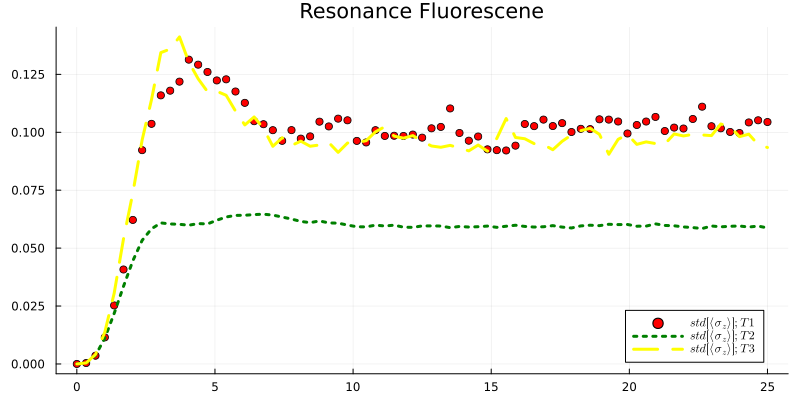

In [14]:
# T1
scatter(t_eval, dropdims(std(r_sample1[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T1", linewidth=3.0, color="red",
    title="Resonance Fluorescene", size=(800, 400))
#scatter!(t_eval, dropdims(std(r_sample1[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T1", linewidth=3, color="red",
#        )
#scatter(t_eval, dropdims(var(r_sample1[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T1", linewidth=3, color="red",
#        title="Variance ")
# T2
plot!(t_eval, dropdims(std(r_sample2[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T2", linewidth=3, color="green",
    title="Resonance Fluorescene", size=(800, 400), line=:dot)
#plot!(t_eval, dropdims(std(r_sample2[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#plot!(t_eval, dropdims(var(r_sample2[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T2", linewidth=3, color="green",
#    line=:dot)
#T3
plot!(t_eval, dropdims(std(r_sample3[3, :, :], dims=2), dims=2), label=L"std[\langle\sigma_z\rangle]; T3", linewidth=3, color="yellow",
    title="Resonance Fluorescene", size=(800, 400), line=:dash)
#plot!(t_eval, dropdims(std(r_sample3[2, :, :], dims=2), dims=2), label=L"std[\langle\sigma_y\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash)
#plot!(t_eval, dropdims(var(r_sample3[1, :, :], dims=2), dims=2), label=L"Var[\langle\sigma_x\rangle]; T3", linewidth=3, color="yellow",
#    line=:dash, xlabel=L"t", ylabel=L"Var\langle\sigma\rangle")